# Task 2: Credit Risk Prediction ¶

**Info about dataset**

Data source: https://www.kaggle.com/datasets/nanditapore/credit-risk-analysis/data

Feature number: 11

Dataset rows: 32581

**Features description:**

ID: Unique identifier for each loan applicant.

Age: Age of the loan applicant.

Income: Income of the loan applicant.

Home: Home ownership status (Own, Mortgage, Rent).

Emp_Length: Employment length in years.

Intent: Purpose of the loan (e.g., education, home improvement).

Amount: Loan amount applied for.

Rate: Interest rate on the loan.

Status: Loan approval status (Fully Paid, Charged Off, Current).

Percent_Income: Loan amount as a percentage of income.

Cred_Length: Length of the applicant's credit history.

**Target:**

Default: Whether the applicant has defaulted on a loan previously (Yes, No).


#       1. Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import pandas as pd
from sklearn.utils import resample

In [2]:
df = pd.read_csv('credit_risk.csv')

In [3]:
df.shape

(32581, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status          32581 non-null  int64  
 9   Percent_income  32581 non-null  float64
 10  Default         32581 non-null  object 
 11  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB


In [5]:
df.isna().sum()

Id                   0
Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64

In [6]:
df = df.drop(['Id'], axis=1)  

In [7]:
df.describe()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Cred_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


**Implement Box plot and Histogram To see if there is outliers**

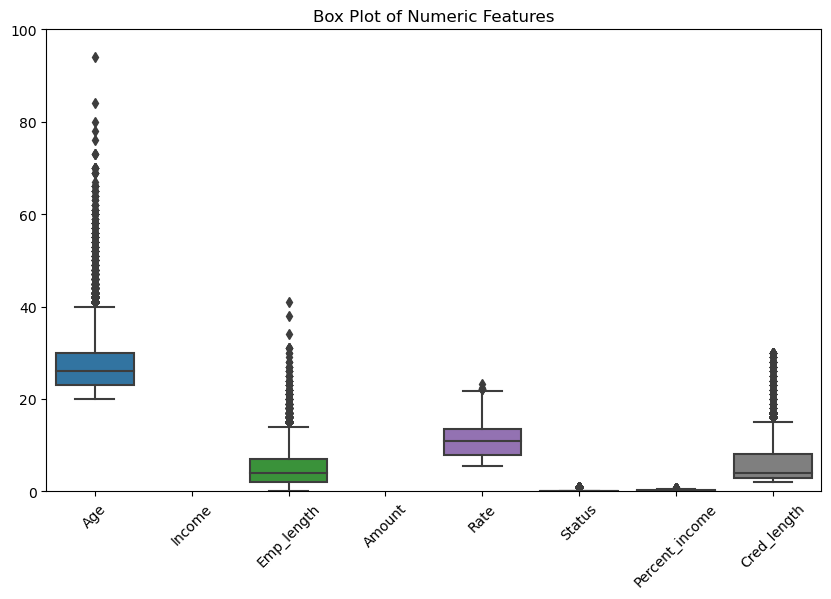

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot for each numeric column 
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)  
plt.xticks(rotation=45)  #
plt.title('Box Plot of Numeric Features')

plt.ylim(0, 100)  
plt.show()


<Figure size 1000x600 with 0 Axes>

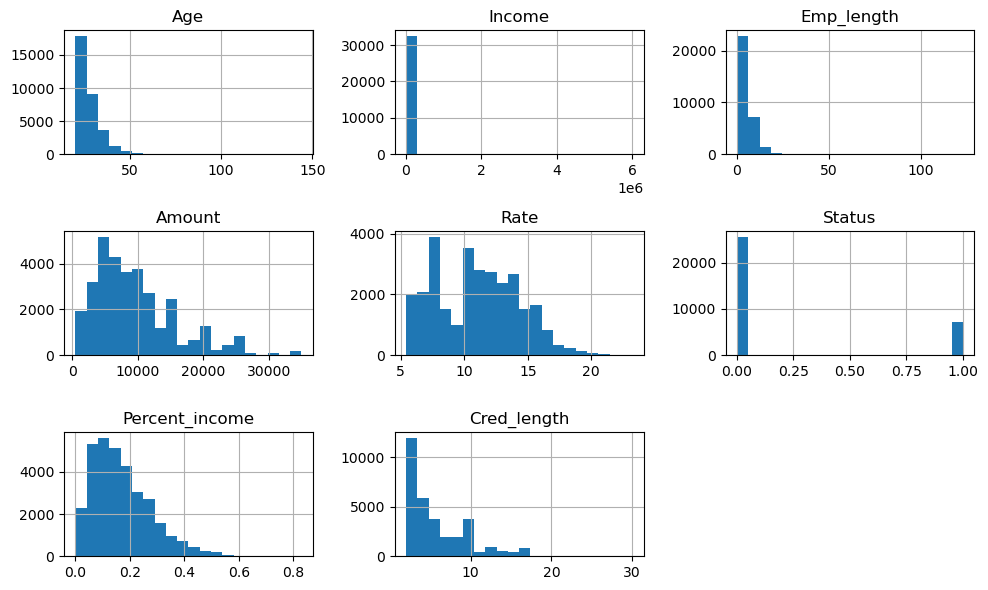

In [9]:
# Create histograms for each numeric column
plt.figure(figsize=(10, 6))
df.hist(bins=20, figsize=(10, 6))
plt.tight_layout()
plt.show()

**Exploring the target**

In [10]:
df['Default'].value_counts()

N    26836
Y     5745
Name: Default, dtype: int64

<Axes: xlabel='Default', ylabel='count'>

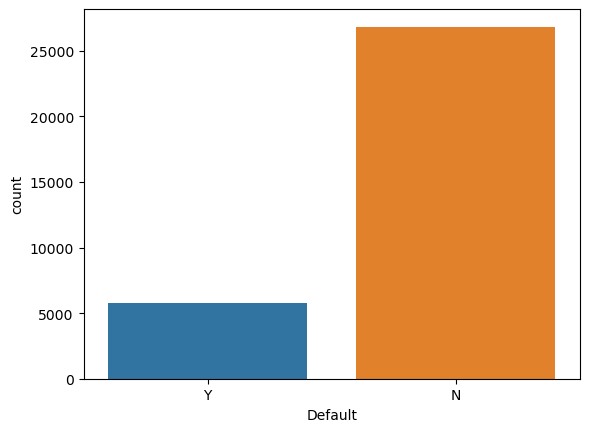

In [11]:
# Plot the frequency of target values
sns.countplot(data=df, x='Default')  #as seen there is imbalance in the target values

**Important observations:**

    1. Data contain outliers

    2. Target is imbalanced
    
    3. Missing values in two columns

# 2. Preprocessing: 
**2.1. Remove outliers  2.2. missing values 2.3. Handling imbalance**

In [12]:
# 2.1. removing the outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    df = remove_outliers_iqr(df, column)

In [13]:
df.shape

(18283, 11)

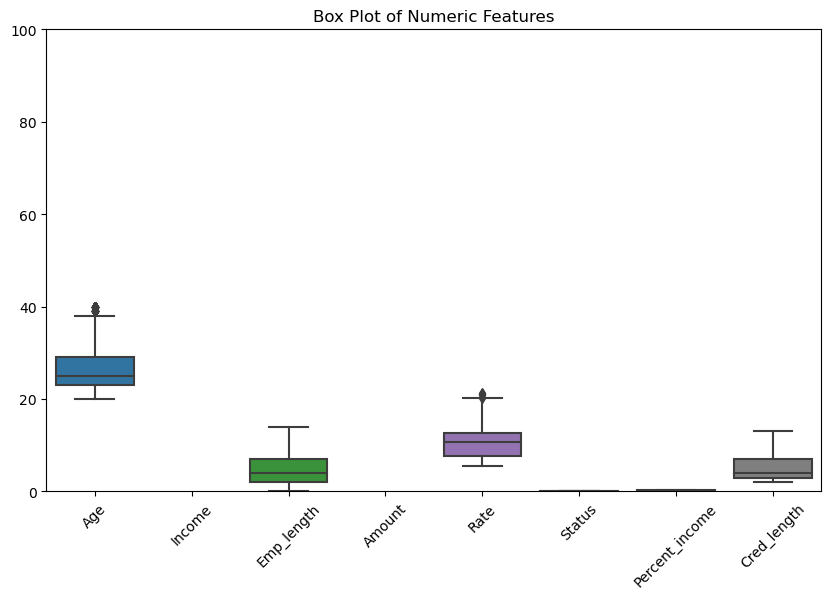

In [14]:
# Create a box plot again to check that outliers are removed
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)  
plt.xticks(rotation=45)  
plt.title('Box Plot of Numeric Features')

plt.ylim(0, 100)  
plt.show()


In [15]:
# 2.2. removing null values using mean

df['Emp_length'].fillna(df['Emp_length'].mean(), inplace=True)
df['Rate'].fillna(df['Rate'].mean(), inplace=True)


In [16]:
df.isna().sum()

Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64

In [17]:
# make label encoding to the target column 'Default'
label_encoder = LabelEncoder()
df['Default'] = label_encoder.fit_transform(df['Default'])

In [18]:
# 2.3. handle imbalance of target 
df_majority = df[df['Default'] == 0]
df_minority = df[df['Default'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    
                                   n_samples=len(df_minority),  
                                   random_state=42)  

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

print(df_downsampled['Default'].value_counts())


0    2555
1    2555
Name: Default, dtype: int64


# 3. Model Training: 
**3.1. xgboost, 3.2. SVM**

In [19]:
categorical_columns = df_downsampled.select_dtypes(include=['object'])

dummy_df = pd.get_dummies(categorical_columns, drop_first=True) 

df_encoded = pd.concat([df_downsampled.drop(columns=categorical_columns.columns), dummy_df], axis=1)


df_encoded.head()


,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Default,Cred_length,Home_OTHER,Home_OWN,Home_RENT,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE
16459,23,35000,7.0,2100,5.42,0,0.06,0,2,0,0,0,0,0,0,0,1
8393,22,57600,6.0,6500,7.49,0,0.11,0,3,0,1,0,0,0,0,0,1
25229,33,81804,4.0,9000,8.00,0,0.11,0,8,0,0,0,0,0,0,0,0
22319,30,54000,8.0,5000,8.00,0,0.09,0,8,0,0,0,0,0,0,1,0
796,26,22000,3.0,3825,10.65,0,0.17,0,4,0,0,0,0,0,0,0,0


In [20]:
# Split train data to fearures and target
X = df_encoded.drop(['Default'], axis=1)  
y = df_encoded['Default']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

**3.1. xgboost**

In [22]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [23]:
import xgboost as xgb

model = xgb.XGBClassifier()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
best_estimator.fit(X_train, y_train)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
# Make predictions on the validation part
y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

print("Validation Classification Report:")
print(classification_report(y_test, y_pred))


Validation Accuracy: 0.913894324853229
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       522
           1       0.86      0.99      0.92       500

    accuracy                           0.91      1022
   macro avg       0.92      0.92      0.91      1022
weighted avg       0.92      0.91      0.91      1022



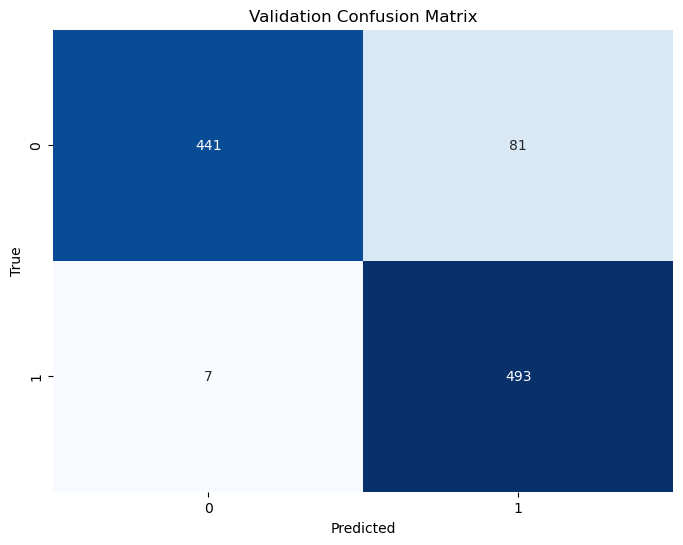

In [25]:
# Get confusion matrix for val set
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

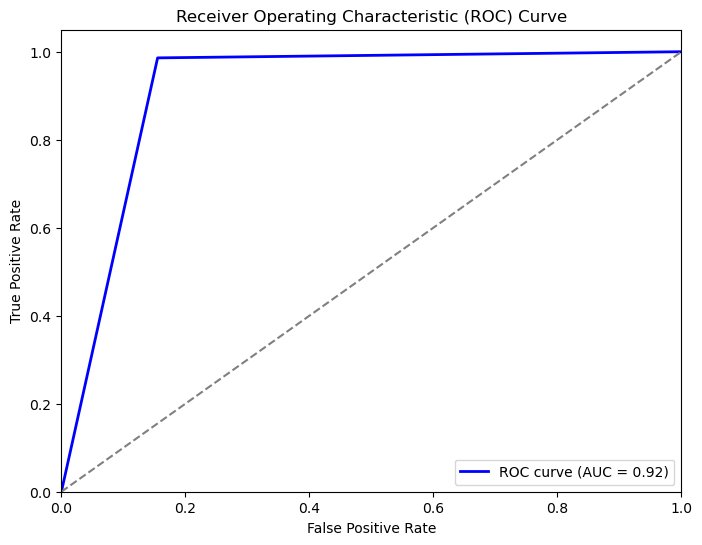

In [26]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**3.2. SVM**

In [27]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')  

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

In [28]:
# Predict on the test data
y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)

print("Validation Classification Report:")
print(classification_report(y_test, y_pred))


Validation Accuracy: 0.8747553816046967
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       522
           1       0.83      0.93      0.88       500

    accuracy                           0.87      1022
   macro avg       0.88      0.88      0.87      1022
weighted avg       0.88      0.87      0.87      1022



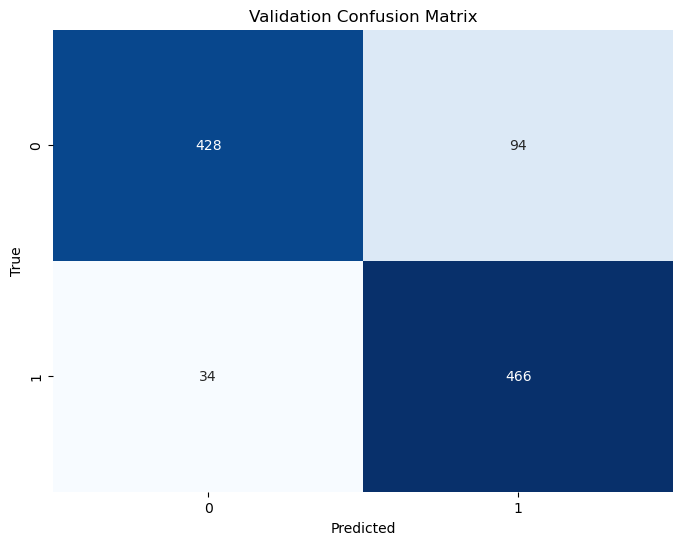

In [29]:
# Get confusion matrix for val set
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

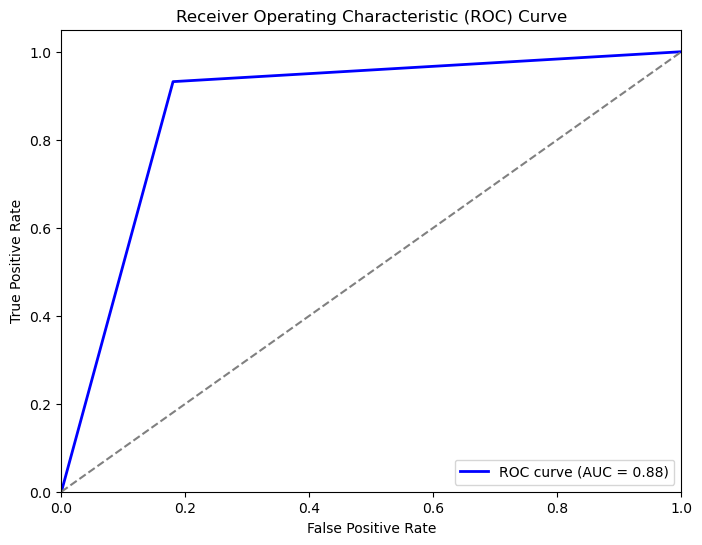

In [30]:
from sklearn.metrics import roc_curve, auc

# Get false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()